### By Team docithurtswhaleIP:
Wenjie Cai & Philipp Schwarz


# Whale Masks with Unet Architecture

Forked and adapted from [Costas Voglis's Kernel](https://www.kaggle.com/voglinio/generalizing-whale-masks-with-masked-results)

This kernel shows how to generate very good masks for the fluke of the whale based on only 450 annotated fluke masks.
For this image segmentation task, we will describe the model architecture - U-NET and the data augmentation we used to mitigate overfitting.
The 450 fluke masks were provided by  Dene originally for the [Humpback Whale Identification Challenge on Kaggle](https://www.kaggle.com/c/whale-categorization-playground) and can be downloaded [here](https://storage.googleapis.com/kaggle-forum-message-attachments/459392/11072/masks.zip). 
Segmenting the fluke and adding it as information in a fourth channel, significantly improved our score on the whale identification challenge. By adding it as a seperate channel the metric learning model can learn to recognize the fluke based on the characteristic contours of the fluke without loosing other potentially valuable information such as the background information of the sea.

We use pretrained keras models from this great repo [segmentation_models](https://github.com/qubvel/segmentation_models) and sophisticated image augmentation using the python package [albumentations](https://github.com/albumentations-team/albumentations).

Fundamentally, the task is single class segmentation. Interestingly, only 450 fluke masks are enough to generalize to the whole train and test set of the kaggle channel and even to the GDSC dataset that has different image properties.

In [1]:
import sys
sys.executable

'/anaconda/envs/kerasgpu/bin/python'

In [2]:
import numpy as np
import pandas as pd

seed = 66
np.random.seed(seed)
import cv2
import json
import glob
import os
from tqdm import *
from shutil  import copyfile, rmtree 
from pathlib import Path

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, SpatialDropout2D, Input
from tensorflow.keras import applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

import tensorflow.keras as keras
import segmentation_models as sm

from tqdm import tqdm_notebook, tqdm

Segmentation Models: using `tf.keras` framework.


In [3]:
tf.__version__

'2.1.0'

One of the key pillars for the creating good masks was to resize the image to an rectangular shape and do not make it quadratic.

In [4]:
DIMENSION = (384, 192)

In [20]:
TRAIN_PATH = '../../earhian/input/train/'
TEST_PATH = '../../earhian/input/test/'
MASK_PATH = '../input/masks/'
WC_PATH = '../WC_input/data/'

Lets begin by parsing the the 450  intial masks

In [21]:
mask_files = os.listdir(MASK_PATH)
# mask_files = [m for m in mask_files if 'mask' in m]
X = []
M = []
for mask_file in mask_files:
    img = cv2.imread(TRAIN_PATH + mask_file)
    mask = cv2.imread(MASK_PATH + mask_file, 0)
    mask[mask>108]= 255
    mask[mask<=108]= 0
    X.append(img)
    M.append(mask)

X = np.array(X)
M = np.array(M)


In [22]:
img_files = os.listdir(WC_PATH)

WC = []
for img_file in img_files:
    img = cv2.imread(WC_PATH + img_file)
    WC.append(img)
WC = np.array(WC)

#### Define Data augmentation transformations

For data augmentation We use albumentations a libary that has a very simple, flexible APWe that allows the library to be plugged in any computer vision pipeline. The library provides almost any thinkable transformation and was written by Kaggle Masters

In [23]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, Rotate,IAAAffine
)

In [24]:
aug_null = Compose([])
aug = Compose([ 
    Blur(p=0.5, blur_limit=2),
    IAAAffine(p=0.5, shear=5),
    HorizontalFlip(p=0.5),              
    Rotate(limit=5, p=0.3),
    RandomContrast(p=0.2, limit=0.1),
    RandomBrightness(p=0.2, limit=0.1),
])


#### Define Data loader

Besides the data loading procedure, here We defined the backbone of the unet model, We use **seresnet34**. In contrast to conventional resnet34, seresnet34 uses an additional trick called **Squeeze-and-Excitation** which often helps the model generalize extremely well. The (SE) block adaptively recalibrates
channel-wise feature responses by explicitly modelling interdependencies between channels. For more information take a look a the original [paper](https://arxiv.org/pdf/1709.01507.pdf)


In [25]:
model_name = 'seresnet34'
BACKBONE = model_name
preprocess_input = sm.get_preprocessing(BACKBONE)

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, M, batch_size=32,
                 dim=DIMENSION,  shuffle=True, 
                 preprocess_input=preprocess_input, 
                 aug=aug_null, min_mask=2 ):
        'Initialization'
        self.X = X
        self.M = M
        self.batch_size = batch_size
        self.n_classes = 1
        self.shuffle = shuffle
        self.preprocess_input = preprocess_input
        self.aug = aug
        self.on_epoch_end()
        self.dim = dim

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((len(self.X) / self.batch_size) / 1) )

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        
        end_index = min((index+1)*self.batch_size, len(self.indexes))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]


        # Generate data
        X, Y = self.__data_generation(indexes)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        batch_size = len(indexes)
        
        # Initialization
        XX = np.empty((batch_size, self.dim[1], self.dim[0], 3), dtype='float32')
        YY = np.empty((batch_size, self.dim[1], self.dim[0], 1), dtype='float32')

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            img = self.X[ID]
            if img.shape[0] != self.dim[0]:
                img = cv2.resize(img, self.dim, cv2.INTER_CUBIC)
            mask = self.M[ID]
            if mask.shape[0] != self.dim[0]:
                mask = cv2.resize(mask, self.dim, cv2.INTER_AREA)
            
            # Store class
            augmented = self.aug(image=img, mask=mask)
            aug_img = augmented['image']
            aug_mask = augmented['mask']
            aug_mask = np.expand_dims(aug_mask, axis=-1)
            aug_mask = aug_mask/255
            
            assert (np.max(aug_mask)<= 1.0 and  np.min(aug_mask) >= 0)
            aug_mask[aug_mask>0.5] = 1
            aug_mask[aug_mask<0.5] = 0
            
            YY[i,] = aug_mask.astype('float32')
            XX[i,] = aug_img.astype('float32')
    
       
        XX = self.preprocess_input(XX)
            
        return XX, YY

We define the default preprocessing for resnet architectures and create train and validation generators (`keras.utils.Sequence`). Note that the data augmentation is only applied on the training generator.

In [26]:
training_generator = DataGenerator(X[:450], M[:450], batch_size=16,  dim=DIMENSION, aug=aug, 
                                   preprocess_input=preprocess_input)
valid_genarator = DataGenerator(X[450:], M[450:], batch_size=16, dim=DIMENSION, aug=aug_null, 
                                preprocess_input=preprocess_input, shuffle=False)

#### Test Data load

In [27]:
x, y= training_generator[7]
np.max(x), x.shape, y.shape, np.max(y), np.unique(y)

(255.0,
 (16, 192, 384, 3),
 (16, 192, 384, 1),
 1.0,
 array([0., 1.], dtype=float32))

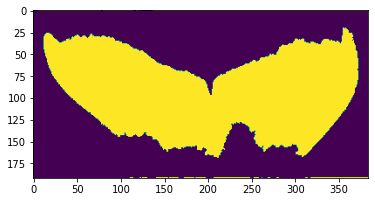

In [29]:
plt.imshow(y[2, ..., 0])
plt.show()

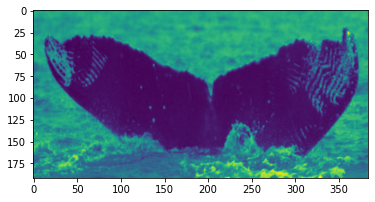

In [30]:
plt.imshow(x[2, ..., 0])
plt.show()

In [31]:
from segmentation_models import Unet
model = Unet(backbone_name=model_name, encoder_weights='imagenet', activation='sigmoid', classes=1)

### U-Net Architecture
The U-NET architecture consists of two paths: encoder and decoder.

The encoder extracts features which contain information about what is in an image using convolutional and pooling layers.

Whilst encoding the size of the feature map gets reduced. The decoder is then used to recover the feature map size for the segmentation image, for which it uses Up-convolution layers.

Because the decoding process loses some of the higher level features the encoder learned, the U-NET has skip connections. That means that the outputs of the encoding layers are passed directly to the decoding layers so that all the important pieces of information can be preserved.

For more information check out the original [paper](https://arxiv.org/pdf/1505.04597.pdf).

![title](u-net-architecture.png)


#### Loss for image segmentation: Dice Coefficient
Simply put, the Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images.

![title](dice_coeff.png)

-----------------------------------------
![title](dice_coeff2.png)

In [32]:
def dice_coeff_L(y_true, y_pred):
    smooth = 1.
    y_pred_sig = tf.nn.sigmoid(y_pred)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred_sig)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_coeff(y_true, y_pred):
#     ipdb.set_trace()
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

Let's train the model to see what we can get.

In [33]:
training_generator = DataGenerator(X[:400], M[:400], batch_size=16,  dim=DIMENSION, aug=aug, 
                                   preprocess_input=preprocess_input)
valid_genarator = DataGenerator(X[400:], M[400:], batch_size=16, dim=DIMENSION, aug=aug_null, 
                                preprocess_input=preprocess_input, shuffle=False)

model.compile(optimizer=Adam(lr=0.001),
          loss=bce_dice_loss,
          metrics=[dice_coeff])

epochs = 40

# Load trained model if exists, otherwise train model
model_file = Path('fpnseresnet34_384-192_34-0.061-0.976.hdf5')
if model_file.is_file():
    model.load_weights(model_file)
else:
    early_stopping = EarlyStopping(patience=10, verbose=1, monitor='val_dice_coeff', mode='max')
    model_checkpoint = ModelCheckpoint("fpnseresnet34_384-192_{epoch:02d}-{val_loss:.3f}-{val_dice_coeff:.3f}.hdf5", 
                                       save_best_only=True, 
                                       save_weights_only=True, 
                                       monitor='val_dice_coeff', verbose=1, mode='max', period=2)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.000001, verbose=1, monitor='val_dice_coeff', mode='max')


    history = model.fit_generator( training_generator,
                                 validation_data=valid_genarator,
                                 epochs=epochs,
                                 callbacks=[ reduce_lr, early_stopping, model_checkpoint], 
                                 verbose=1)

Lets now define the `TestDataGenerator` class that also extends `keras.utils.Sequence` but ignores masks. This generator will be used for inference. 

In [34]:
aug_null = Compose([])


class TestDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, batch_size=32,
                 dim=(299,299),  shuffle=True, 
                 preprocess_input=preprocess_input, 
                 aug=aug_null, min_mask=2 ):
        'Initialization'
        self.X = X
        self.batch_size = batch_size
        self.n_classes = 1
        self.shuffle = shuffle
        self.preprocess_input = preprocess_input
        self.aug = aug
        self.dim = dim
        self.on_epoch_end()

    def set_aug(self, aug):
        self.aug = aug
        self.on_epoch_end()
      
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((len(self.X) / self.batch_size) / 1) )

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        
        end_index = min((index+1)*self.batch_size, len(self.indexes))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs

        # Generate data
        xx = self.__data_generation(indexes)

        return xx

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        batch_size = len(indexes)
        
        # Initialization
        XX = np.empty((batch_size, self.dim[1], self.dim[0], 3), dtype='float32')

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            img = self.X[ID]
            if img.shape[0] != self.dim[0]:
                img = cv2.resize(img, self.dim, cv2.INTER_CUBIC)
            
            
            # Store class
            augmented = self.aug(image=img)
            aug_img = augmented['image']
            if aug_img.shape[1] != self.dim[1]:
                aug_img = cv2.resize(aug_img, self.dim, cv2.INTER_CUBIC)
            XX[i,] = aug_img.astype('float32')
    
       
        XX = self.preprocess_input(XX)

        return XX

### Make Predicitions on GDSC dataset

We use Test-time augmentation (TTA) which applies also data augmentation to the test dataset and by averaging predictions, we achieve a little bit more robust masks.

In [35]:
null_aug = Compose([])
test_generator = TestDataGenerator(WC, batch_size=16, aug=null_aug, preprocess_input=preprocess_input, dim=DIMENSION, 
                               shuffle=False)
preds = model.predict_generator(test_generator, verbose=1)

flip_aug = Compose([HorizontalFlip(p=1.0) ])
test_generator = TestDataGenerator(WC, batch_size=16, aug=flip_aug, preprocess_input=preprocess_input,  dim=DIMENSION, shuffle=False)
preds_hflip = model.predict_generator(test_generator, verbose=1)

blur_aug = Compose([Blur(p=1.0)])
test_generator = TestDataGenerator(WC, batch_size=16, aug=blur_aug, preprocess_input=preprocess_input,  dim=DIMENSION, shuffle=False)
preds_blur = model.predict_generator(test_generator, verbose=1)


Instructions for updating:
Please use Model.predict, which supports generators.
334/334 [==============================] - 125s 373ms/step


In [36]:
TARGET_VAL = []
for i in range(len(preds)):
    pp = (preds[i] + np.fliplr(preds_hflip[i]) + preds_blur[i])/3
    TARGET_VAL.append(pp)

TARGET_VAL = np.array(TARGET_VAL)  

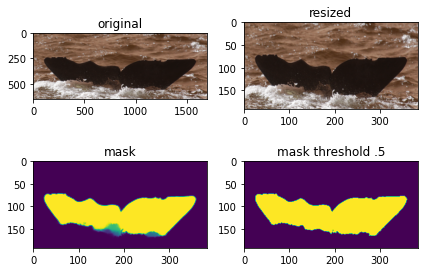

In [55]:
from skimage.morphology import label

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.imshow(WC[3])

ax2 = fig.add_subplot(222)
ax2.imshow(cv2.resize(WC[3], DIMENSION))

ax3 = fig.add_subplot(223)
ax3.imshow(TARGET_VAL[3][:,:, 0])

x = TARGET_VAL[3]
x = label(x > .5)
ax4 = fig.add_subplot(224)
ax4.imshow(x[:, :, 0])


ax1.title.set_text('original')
ax2.title.set_text('resized')
ax3.title.set_text('mask')
ax4.title.set_text('mask threshold .5')
plt.tight_layout()
plt.show()

### Make Predicitions on Kaggle Dataset

When we want to use the whale tails provided by Kaggle for pretraining, we should also create masks on this dataset.

In [ ]:
# null_aug = Compose([])
# valid_genarator = DataGenerator(X[450:], M[450:], batch_size=16, aug=null_aug, preprocess_input=preprocess_input, dim=DIMENSION, 
#                                shuffle=False)
# preds = model.predict_generator(valid_genarator, verbose=1)

# flip_aug = Compose([HorizontalFlip(p=1.0) ])
# valid_genarator = DataGenerator(X[450:], M[450:], batch_size=16, aug=flip_aug, preprocess_input=preprocess_input,  dim=DIMENSION, shuffle=False)
# preds_hflip = model.predict_generator(valid_genarator, verbose=1)

# blur_aug = Compose([Blur(p=1.0)])
# valid_genarator = DataGenerator(X[450:], M[450:], batch_size=16, aug=blur_aug, preprocess_input=preprocess_input,  dim=DIMENSION, shuffle=False)
# preds_blur = model.predict_generator(valid_genarator, verbose=1)

# TARGET_VAL = []
# for i in range(len(preds)):
#     pp = (preds[i])# + np.fliplr(preds_hflip[i]) + preds_blur[i])/3
#     TARGET_VAL.append(pp)

# TARGET_VAL = np.array(TARGET_VAL)  

The nice side effect from segmenting the whale flukes is that we can get tight bounding boxes as well. In the figure bellow we keep a tight bounding box and only pixels that correspond to the mask. There are several ways to move from here:
#### Draw masked flukes on white background

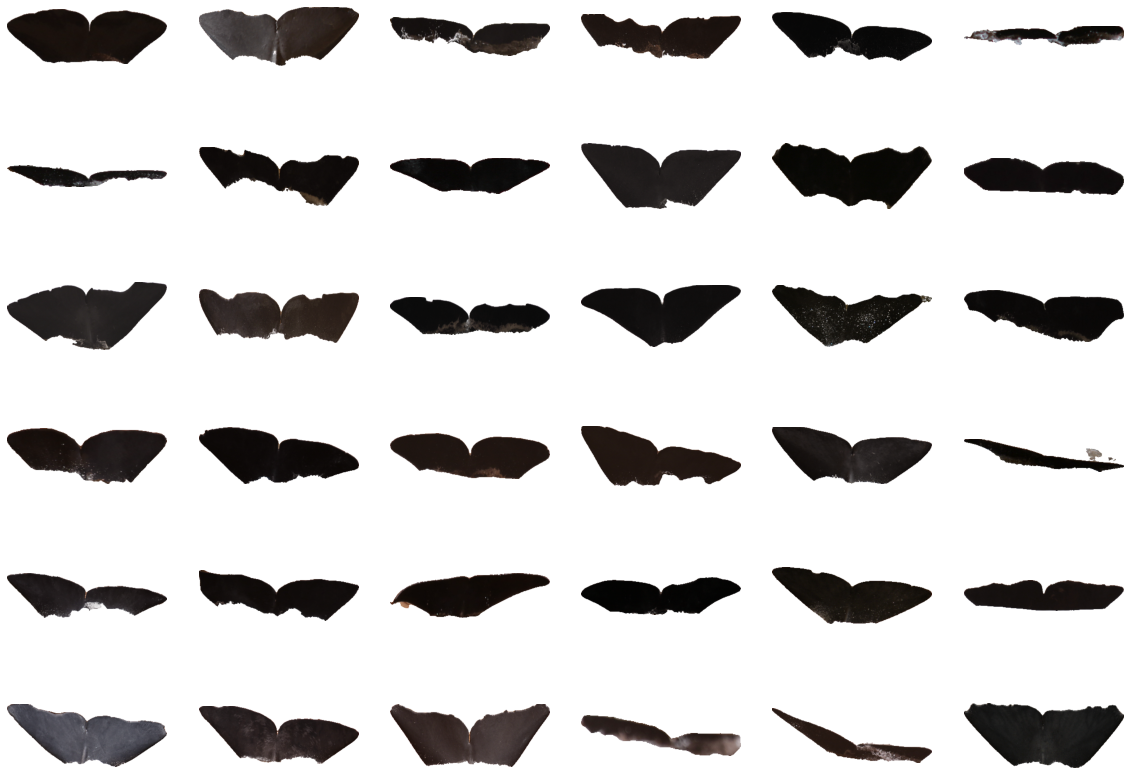

In [56]:
SIZE = 384
f, axarr = plt.subplots(6, 6)
f.set_figwidth(20)
f.set_figheight(15)
kernel = np.ones((3,3),np.uint8)

for i in range(0, 36):
    img =  cv2.resize(WC[i], DIMENSION)
    mask = ((TARGET_VAL[i, ..., 0]) > 0.25).astype('uint8')
    if mask.max()==0:
        axarr[int(i/6), i%6].imshow(img, cmap='gray')
        axarr[int(i/6), i%6].axis('off')
        continue
    back = ((TARGET_VAL[i, ..., 0]) <= 0.25).astype('uint8')

    img = np.stack([img[..., j] * mask + back*255 for j in range(3)], axis=-1)
    
    contours,hierarchy = cv2.findContours(mask, 1, 2)
  # Cycle through contours and add area to array
    areas = []
    for c in contours:
        areas.append(cv2.contourArea(c))

    # Sort array of areas by size
    sorted_areas = sorted(zip(areas, contours), key=lambda x: x[0], reverse=True)
    title = str(len(sorted_areas)) 
    
    cnt = sorted_areas[0][1]
    x1,y1,w,h = cv2.boundingRect(cnt)
    x2 = x1 + w
    y2 = y1 + h
    
    for j in range(1, len(sorted_areas)):
        cnt = sorted_areas[j][1]
        tx1,ty1,tw,th = cv2.boundingRect(cnt)
        tx2 = tx1 + tw
        ty2 = ty1 + th
        x1 = min(x1, tx1)
        y1 = min(y1, ty1)
        x2 = max(x2, tx2)
        y2 = max(y2, ty2)
    
    x = x1
    y = y1
    w = x2-x1
    h = y2-y1


    img_cropped = img[y:y+h, x:x+w]
    axarr[int(i/6), i%6].imshow(img_cropped, cmap='gray')
    axarr[int(i/6), i%6].axis('off')
plt.show()